In [1]:
import numpy as np 
import tensorflow 
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt
import cv2

2023-11-14 20:52:53.738290: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-14 20:52:53.769832: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-14 20:52:53.769866: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-14 20:52:53.770777: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-14 20:52:53.776469: I tensorflow/core/platform/cpu_feature_guar

(a) We will use the MNIST dataset for tranining and testing here. 

In [2]:
(X_train, Y_train), (X_test, Y_test) = mnist.load_data() 
train_idx_0 = np.argwhere(Y_train==0)
train_idx_1 = np.argwhere(Y_train==1)
test_idx_0 = np.argwhere(Y_test==0)
test_idx_1 = np.argwhere(Y_test==1)
x_train = [] 
y_train = [] 
x_test = [] 
y_test = [] 
for i in range(len(train_idx_0)):
  idx = train_idx_0[i][0]
  temp = cv2.resize(X_train[idx], (14,14))
  x_train.append(temp.flatten())
  y_train.append(Y_train[idx])

for i in range(len(train_idx_1)):
  idx = train_idx_1[i][0]
  temp = cv2.resize(X_train[idx], (14,14))
  x_train.append(temp.flatten())
  y_train.append(Y_train[idx])

for i in range(len(test_idx_0)):
  idx = test_idx_0[i][0]
  temp = cv2.resize(X_test[idx], (14,14))
  x_test.append(temp.flatten())
  y_test.append(Y_test[idx])

for i in range(len(test_idx_1)):
  idx = test_idx_1[i][0]
  temp = cv2.resize(X_test[idx], (14,14))
  x_test.append(temp.flatten())
  y_test.append(Y_test[idx])

x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)
idx_train=np.array(range(len(y_train)))
idx_test=np.array(range(len(y_test)))
np.random.shuffle(idx_train)
np.random.shuffle(idx_test)
x_tr = []
x_te = []
y_tr = []
y_te = []
for i in range(len(idx_train)):
  x_tr.append(x_train[idx_train[i]].flatten())
  y_tr.append(y_train[idx_train[i]])
for i in range(len(idx_test)):
  x_te.append(x_test[idx_test[i]].flatten())
  y_te.append(y_test[idx_test[i]])
x_tr = np.nan_to_num(np.array(x_tr)/np.sum(x_tr,axis=0)) 
x_te = np.nan_to_num(np.array(x_te)/np.sum(x_tr,axis=0)) 
y_tr = np.array(y_tr)
y_te = np.array(y_te)
y_train = [] 
y_test = [] 
for i in range(len(y_tr)): 
  if y_tr[i] == 1:
    y_train.append(-1)
  else:
     y_train.append(1)

for i in range(len(y_te)): 
  if y_te[i] == 1:
    y_test.append(-1)
  else:
     y_test.append(1)
y_tr = np.array(y_train)
y_te = np.array(y_test)

/tmp/ipykernel_1051500/321430160.py:52: RuntimeWarning: invalid value encountered in divide
  x_tr = np.nan_to_num(np.array(x_tr)/np.sum(x_tr,axis=0))
/tmp/ipykernel_1051500/321430160.py:53: RuntimeWarning: invalid value encountered in divide
  x_te = np.nan_to_num(np.array(x_te)/np.sum(x_tr,axis=0))


(b) 

Funtion grad_h implements the gradient for logistic regression. Function train_gd trains the model with a gradient descent algorithm. Function loss computes the logistic loss. 

In [3]:
def grad_h(w,x,y,lam,w0): 
  ##Paramaters: 
  # w: weight matrix (cxd array)
  # x: data matrix (nxd array)
  # y: true label array (nx1 array)
  # lam: regularization constant (constant)
  # w0: bias matrix (cxn array)
  #Output: grad (cxd array)
  n = np.shape(x)[0]
  grad = -(1/n)*np.matmul(x.T,((y*(np.exp(-y*(np.matmul(w,x.T)+w0)))).T) /(np.exp(-y*(np.matmul(w,x.T)+w0))+1).T)+lam*w.T
  return grad.T

def get_grad(w, lambda_i, X, Y, w0 = 0):
    print(w.shape, X.shape, Y.shape, w0)
    sigmoid_arg = np.exp(-Y*(X@w + w0))
    sigmoid = sigmoid_arg/(1+sigmoid_arg)
    grad = -(1/X.shape[0])* sigmoid@(Y[:, np.newaxis]*X)+ lambda_i*w
    gradw0 = -Y*sigmoid*(1/X.shape[0]) + lambda_i*w0
    return grad, gradw0

def get_loss(w, lambda_i, X, Y, w0 = 0):
    loss = (1/X.shape[0])*(np.log(1+np.exp(-Y*(X@w + w0)))).sum(axis = 0) + (lambda_i/2)*(np.linalg.norm(w)**2 + w0**2)
    return loss 

def train_gd(x_tr, y_tr, lam, lr, n_iter, w0=0,w_0 = None):
  ##Paramaters: 
  # x_tr: data matrix (nxd array)
  # y_tr: true label array (nx1 array)
  # lam: regularization constant (constant)
  # lr: learning rate 
  # n_iter: number of iteration steps 
  # w0: bias matrix (cxn array)
  #Output: grad (cxd array)
  c = 2   
  d = np.shape(x_tr)[1]
  w = w_0 or np.random.rand(c,d)
  w_all = []
  t = 0 
  while t <= n_iter: 
    # print(w.shape)
    # if (np.all(np.abs(grad_h(w, x_tr, y_tr, lam, w0)[0] - get_grad(w[0], lam, x_tr, y_tr, 0)) < 1e-3)) == False:
    #    print("False")
    
    w = w - lr*grad_h(w,x_tr,y_tr,lam,w0)
    w_all.append(w)
    t += 1 
  return np.array(w_all) 

def train_gd2(x_tr, y_tr, lam, lr, n_iter, w0=0,w_0 = None):
  ##Paramaters: 
  # x_tr: data matrix (nxd array)
  # y_tr: true label array (nx1 array)
  # lam: regularization constant (constant)
  # lr: learning rate 
  # n_iter: number of iteration steps 
  # w0: bias matrix (cxn array)
  #Output: grad (cxd array)
  c = 2   
  d = np.shape(x_tr)[1]
  wt = np.random.standard_normal((14*14))
  w0 = 0
  w_all = []
  w0_all = []
  t = 0 
  while t <= n_iter: 
    gradw, gradw0 = get_grad(w=wt, X= x_tr, Y= y_tr, lambda_i=lam, w0 = w0)
    wt = wt - lr*gradw
    w0 = w0 - lr*gradw0
    w_all.append(wt)
    w0_all.append(w0)
    t += 1 
  return np.array(w_all), np.array(w0_all) 

def loss(w, x, y, lam, w0=0):
  ##Paramaters: 
  # x_tr: data matrix (nxd array)
  # y_tr: true label array (nx1 array)
  # lam: regularization constant (constant)
  # lr: learning rate 
  # n_iter: number of iteration steps 
  # w0: bias matrix (cxn array)
  #Output: grad (cxd array)
  l1 = np.sum(np.log(1 + np.exp(-y*(np.matmul(w,x.T)+w0))+1),axis=1)/np.shape(y_tr)[0] 
  l2 = (lam/2)*((np.linalg.norm(w)*np.linalg.norm(w)) + (np.linalg.norm(w0)*np.linalg.norm(w0)))
  return l1 + l2

def logit(w, x, w0=0):
  ##Paramaters: 
  # x_tr: data matrix (nxd array)
  # y_tr: true label array (nx1 array)
  # lam: regularization constant (constant)
  # lr: learning rate 
  # n_iter: number of iteration steps 
  # w0: bias matrix (cxn array)
  #Output: grad (cxd array)
  y_0 = 1 
  y_1 = -1 
  p = lambda x, y, w, w0: (np.exp(-y*(np.matmul(w,x.T)+w0))+1)**(-1)
  prob = np.array([p(x,y_0,w,w0),p(x,y_1,w,w0)]) 
  idx = np.argmax(prob)
  return idx 

def get_grad(w, lambda_i, X, Y, w0 = 0):
    sigmoid_arg = np.exp(-Y*(X@w + w0))
    sigmoid = sigmoid_arg/(1+sigmoid_arg)
    grad = -(1/X.shape[0])* sigmoid@(Y[:, np.newaxis]*X)+ lambda_i*w
    gradw0 = -Y*sigmoid*(1/X.shape[0]) + lambda_i*w0
    return grad, gradw0

def get_loss(w, lambda_i, X, Y, w0 = 0):
    loss = (1/X.shape[0])*(np.log(1+np.exp(-Y*(X@w + w0)))).sum(axis = 0) + (lambda_i/2)*(np.linalg.norm(w)**2 + w0**2)
    return loss


Trained weights now produced. Regularization constant varied, learning rate set to 0.01, trained over 50 time-steps.

In [4]:
lambdas = [1,10,20,30,40,50,70] ##regularization parameter 
w_d = 0.01 ##learning rate 
T_max = 50  #max iterations 
w_all_1= train_gd(x_tr, y_tr, lambdas[0], w_d, T_max)
w_all_2= train_gd(x_tr, y_tr, lambdas[1], w_d, T_max)
w_all_3= train_gd(x_tr, y_tr, lambdas[2], w_d, T_max)
w_all_4= train_gd(x_tr, y_tr, lambdas[3], w_d, T_max)
w_all_5= train_gd(x_tr, y_tr, lambdas[4], w_d, T_max)
w_all_6= train_gd(x_tr, y_tr, lambdas[5], w_d, T_max)
w_all_7= train_gd(x_tr, y_tr, lambdas[6], w_d, T_max)
loss_tr_1 = [loss(w,x_tr, y_tr, lambdas[0])[0] for w in w_all_1]
loss_tr_2 = [loss(w,x_tr, y_tr, lambdas[1])[0] for w in w_all_2]
loss_tr_3 = [loss(w,x_tr, y_tr, lambdas[2])[0] for w in w_all_3]
loss_tr_4 = [loss(w,x_tr, y_tr, lambdas[3])[0] for w in w_all_4]
loss_tr_5 = [loss(w,x_tr, y_tr, lambdas[4])[0] for w in w_all_5]
loss_tr_6 = [loss(w,x_tr, y_tr, lambdas[5])[0] for w in w_all_6]
loss_tr_7 = [loss(w,x_tr, y_tr, lambdas[6])[0] for w in w_all_7]

In [5]:
wt = np.random.standard_normal((14*14))
w0 = 0
w_all = []
t = 0 

gradw, gradw0 = get_grad(w=wt, X= x_tr, Y= y_tr, lambda_i=lambdas[0], w0 = w0)
print(wt.shape, x_tr.shape, y_tr.shape)

(196,) (12665, 196) (12665,)


In [6]:
x_tr.shape

(12665, 196)

In [7]:
wt.shape

(196,)

In [8]:
w_all_1_a, w0_all_1 = train_gd2(x_tr, y_tr, lambdas[0], w_d, T_max)
w_all_2_a, w0_all_2 = train_gd2(x_tr, y_tr, lambdas[1], w_d, T_max)
w_all_3_a, w0_all_3 = train_gd2(x_tr, y_tr, lambdas[2], w_d, T_max)
w_all_4_a, w0_all_4 = train_gd2(x_tr, y_tr, lambdas[3], w_d, T_max)
w_all_5_a, w0_all_5 = train_gd2(x_tr, y_tr, lambdas[4], w_d, T_max)
w_all_6_a, w0_all_6 = train_gd2(x_tr, y_tr, lambdas[5], w_d, T_max)
w_all_7_a, w0_all_7 = train_gd2(x_tr, y_tr, lambdas[6], w_d, T_max)

In [9]:
loss_tr_1_a = [get_loss(w=w,X=x_tr, Y=y_tr, lambda_i=lambdas[0], w0=w0)[0] for w, w0 in zip(w_all_1_a, w0_all_1)]
loss_tr_2_a = [get_loss(w=w,X=x_tr, Y=y_tr, lambda_i=lambdas[1], w0=w0)[0] for w, w0 in zip(w_all_2_a, w0_all_2)]
loss_tr_3_a = [get_loss(w=w,X=x_tr, Y=y_tr, lambda_i=lambdas[2], w0=w0)[0] for w, w0 in zip(w_all_3_a, w0_all_3)]
loss_tr_4_a = [get_loss(w=w,X=x_tr, Y=y_tr, lambda_i=lambdas[3], w0=w0)[0] for w, w0 in zip(w_all_4_a, w0_all_4)]
loss_tr_5_a = [get_loss(w=w,X=x_tr, Y=y_tr, lambda_i=lambdas[4], w0=w0)[0] for w, w0 in zip(w_all_5_a, w0_all_5)]
loss_tr_6_a = [get_loss(w=w,X=x_tr, Y=y_tr, lambda_i=lambdas[5], w0=w0)[0] for w, w0 in zip(w_all_6_a, w0_all_6)]
loss_tr_7_a = [get_loss(w=w,X=x_tr, Y=y_tr, lambda_i=lambdas[6], w0=w0)[0] for w, w0 in zip(w_all_7_a, w0_all_7)]

In [10]:
import matplotlib.pyplot as plot

Gradient descent training loss plotted over iteration number in semi-log scale. Shows initial linear drop, prior to convergence. 

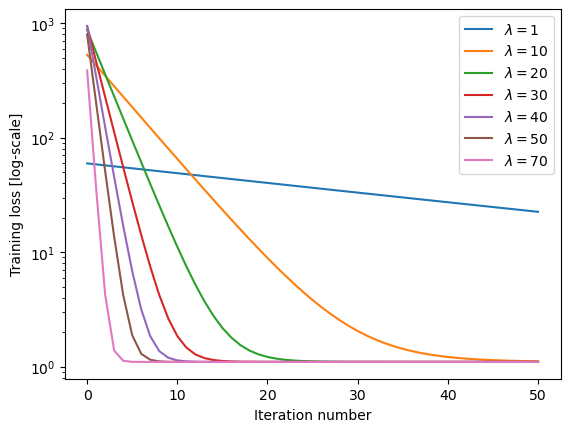

In [11]:
t_rng = np.array(range(len(w_all_1))) 
plot.semilogy(t_rng, loss_tr_1)
plot.semilogy(t_rng, loss_tr_2)
plot.semilogy(t_rng, loss_tr_3)
plot.semilogy(t_rng, loss_tr_4)
plot.semilogy(t_rng, loss_tr_5)
plot.semilogy(t_rng, loss_tr_6)
plot.semilogy(t_rng, loss_tr_7)
plot.legend(('$\lambda = 1$','$\lambda = 10$','$\lambda = 20$','$\lambda = 30$','$\lambda = 40$','$\lambda = 50$','$\lambda = 70$') )
plot.ylabel('Training loss [log-scale]')
plot.xlabel('Iteration number')
plot.show()

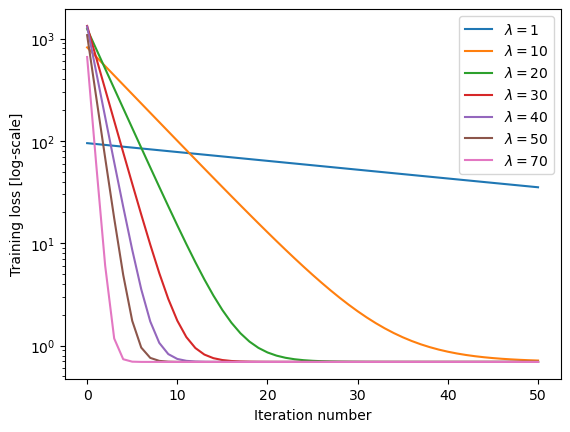

In [12]:
t_rng = np.array(range(len(w_all_1_a))) 
plot.semilogy(t_rng, loss_tr_1_a)
plot.semilogy(t_rng, loss_tr_2_a)
plot.semilogy(t_rng, loss_tr_3_a)
plot.semilogy(t_rng, loss_tr_4_a)
plot.semilogy(t_rng, loss_tr_5_a)
plot.semilogy(t_rng, loss_tr_6_a)
plot.semilogy(t_rng, loss_tr_7_a)
plot.legend(('$\lambda = 1$','$\lambda = 10$','$\lambda = 20$','$\lambda = 30$','$\lambda = 40$','$\lambda = 50$','$\lambda = 70$') )
plot.ylabel('Training loss [log-scale]')
plot.xlabel('Iteration number')
plot.show()

From this, we can extract the slope for each loss function as done below (in log-scale).  

---



In [ ]:
fit_1 = z = np.polyfit(t_rng[0:20], np.log(loss_tr_1[0:20]), 1)
fit_2 = z = np.polyfit(t_rng[0:20], np.log(loss_tr_2[0:20]), 1)
fit_3 = z = np.polyfit(t_rng[0:20], np.log(loss_tr_3[0:20]), 1)
fit_4 = z = np.polyfit(t_rng[0:20], np.log(loss_tr_4[0:20]), 1)
fit_5 = z = np.polyfit(t_rng[0:20], np.log(loss_tr_5[0:20]), 1)
fit_6 = z = np.polyfit(t_rng[0:20], np.log(loss_tr_6[0:20]), 1)
fit_7 = z = np.polyfit(t_rng[0:20], np.log(loss_tr_7[0:20]), 1)

In [ ]:
print("Lambda = 1:"+" "+ str(fit_1[0]))
print("Lambda = 10:"+" "+ str(fit_2[0]))
print("Lambda = 20:"+" "+ str(fit_3[0]))
print("Lambda = 30:"+" "+ str(fit_4[0]))
print("Lambda = 40:"+" "+ str(fit_5[0]))
print("Lambda = 50:"+" "+ str(fit_6[0]))
print("Lambda = 70:"+" "+ str(fit_7[0]))

We find that that the optimal $\lambda$ is $\lambda = 10$. The loss function for larger $\lambda$ begins to saturate. After $\lambda = 50$, bias dominates due to regularization.  Hence, we will take $\lambda = 10$ with a slope of -0.32, corresponding to a condition nubmer $\kappa = 3.12$.   

(d) 

The model is now trained using Nesterov's momentum. 

In [ ]:
def train_nest(x_tr, y_tr, rho, lam, lr, n_iter, w0=0,w_0 = None):  
  ##Paramaters: 
  # x_tr: data matrix (nxd array)
  # y_tr: true label array (nx1 array)
  # rho: momentum parameter 
  # lam: regularization constant (constant)
  # lr: learning rate 
  # n_iter: number of iteration steps 
  # w0: bias matrix (cxn array)
  #Output: grad (cxd array)
  
  w_all = []
  t = 0 
  c = 2  
  d = np.shape(x_tr)[1]
  u =  w_0 or np.random.rand(c,d)
  w =  w_0 or np.random.rand(c,d)
  while t <= n_iter: 
    u_next = w - lr * grad_h(w,x_tr,y_tr,lam,w0)
    w = (1 + rho) * u_next - rho * u
    u = u_next
    w_all.append(w)
    t += 1 
  return np.array(w_all)

We can now look at the trend in training loss for different momentum values (fixed at $\lambda = 10$). Each value of $\rho$ will correspond to a $\kappa$. We will use $\rho = 0.75, 0.8, 0.85, 0.9, 0.95$. 

In [ ]:
rho = [0.75, 0.8, 0.85, 0.9, 0.95] 
lam = 10 
lr = 0.01
T_max = 100
w_all_1 = train_nest(x_tr, y_tr,rho[0],lam, lr, T_max)
w_all_2 = train_nest(x_tr, y_tr,rho[1],lam, lr, T_max)
w_all_3 = train_nest(x_tr, y_tr,rho[2],lam, lr, T_max)
w_all_4 = train_nest(x_tr, y_tr,rho[3],lam, lr, T_max)
w_all_5 = train_nest(x_tr, y_tr,rho[4],lam, lr, T_max)
loss_tr_1 = [loss(w,x_tr, y_tr, lam)[0] for w in w_all_1]
loss_tr_2 = [loss(w,x_tr, y_tr, lam)[0] for w in w_all_2]
loss_tr_3 = [loss(w,x_tr, y_tr, lam)[0] for w in w_all_3]
loss_tr_4 = [loss(w,x_tr, y_tr, lam)[0] for w in w_all_4]
loss_tr_5 = [loss(w,x_tr, y_tr, lam)[0] for w in w_all_5]

In [ ]:
t_rng = np.array(range(len( loss_tr_1))) 
plot.semilogy(t_rng, loss_tr_1)
plot.semilogy(t_rng, loss_tr_2)
plot.semilogy(t_rng, loss_tr_3)
plot.semilogy(t_rng, loss_tr_4)
plot.semilogy(t_rng, loss_tr_5)
plot.legend(('$p = 0.75$','$p = 0.80$','$p = 0.85$','$p = 0.90$','$p = 0.95$') )
plot.ylabel('Training loss [log-scale]')
plot.xlabel('Iteration number')
plot.show()

In [ ]:
fit_1 = z = np.polyfit(t_rng[0:20], np.log(loss_tr_1[0:20]), 1)
fit_2 = z = np.polyfit(t_rng[0:20], np.log(loss_tr_2[0:20]), 1)
fit_3 = z = np.polyfit(t_rng[0:20], np.log(loss_tr_3[0:20]), 1)
fit_4 = z = np.polyfit(t_rng[0:20], np.log(loss_tr_4[0:20]), 1)
fit_5 = z = np.polyfit(t_rng[0:20], np.log(loss_tr_5[0:20]), 1)
print("Rho = 0.75:"+" "+ str(fit_1[0]))
print("Rho =  0.80:"+" "+ str(fit_2[0]))
print("Rho =  0.85:"+" "+ str(fit_3[0]))
print("Rho =  0.90:"+" "+ str(fit_4[0]))
print("Rho =  0.95:"+" "+ str(fit_5[0]))

(e) 

In [ ]:
def train_sgd_minibatch(x_tr, y_tr, B, lam, lr, n_iter, w0=0,w_0 =None):
  ##Paramaters: 
  # x_tr: data matrix (nxd array)
  # y_tr: true label array (nx1 array)
  # lam: regularization constant (constant)
  # lr: learning rate 
  # n_iter: number of iteration steps 
  # w0: bias matrix (cxn array)
  #Output: grad (cxd array)
  c = 2   
  n = np.shape(x_tr)[0]
  d = np.shape(x_tr)[1]
  w = w_0 or np.random.rand(c,d)
  w_all = []
  w_all.append(w)
  t = 0 
  while t <= n_iter:  
    ii = np.random.randint(n, size=B)
    x = x_tr[ii]
    y = y_tr[ii]
    w = w - lr*grad_h(w,x,y,lam,w0)
    w_all.append(w)
    t += 1 
  return np.array(w_all)  

In [ ]:
lam = 10 
B = 128 
lr = 0.01 
T = 100
w_all = train_sgd_minibatch(x_tr, y_tr,B,lam, lr, T)
loss_tr = [loss(w,x_tr, y_tr, lam)[0] for w in w_all]

In [ ]:
t_rng = np.array(range(len(w_all))) 
plot.semilogy(t_rng, loss_tr)
plot.ylabel('Training loss [log-scale]')
plot.xlabel('Iteration number')
plot.show()

In [ ]:
def train_sgd_minibatch_nest(x_tr, y_tr, B, rho, lam, lr, n_iter, w0=0,w_0 =None):
  ##Paramaters: 
  # x_tr: data matrix (nxd array)
  # y_tr: true label array (nx1 array)
  # lam: regularization constant (constant)
  # lr: learning rate 
  # n_iter: number of iteration steps 
  # w0: bias matrix (cxn array)
  #Output: grad (cxd array)
  c = 2   
  n = np.shape(x_tr)[0]
  d = np.shape(x_tr)[1]
  u =  w_0 or np.random.rand(c,d)
  w =  w_0 or np.random.rand(c,d)
  w_all = []
  w_all.append(w)
  t = 0 
  while t <= n_iter:  
    ii = np.random.randint(n, size=B)
    x = x_tr[ii]
    y = y_tr[ii]
    u_next = w - lr * grad_h(w,x,y,lam,w0)
    w = (1 + rho) * u_next - rho * u
    u = u_next
    w_all.append(w)
    t += 1 
  return np.array(w_all)  

Plot of loss for 4 algorithms, with $\rho = 0.9$. 

```
# This is formatted as code
```



In [ ]:
lam = 10 
B = 128 
lr = 0.01 
T = 100 
rho = 0.75 
w_gd  = train_gd(x_tr, y_tr, lam, lr, T)
w_nest_gd  = train_nest(x_tr, y_tr,rho,lam, lr, T)
w_sgd = train_sgd_minibatch(x_tr, y_tr,B,lam, lr, T)
w_nest_sgd = train_sgd_minibatch_nest(x_tr, y_tr,B, rho, lam, lr, T)

loss_gd = [loss(w,x_tr, y_tr, lam)[0] for w in w_gd]
loss_nest_gd = [loss(w,x_tr, y_tr, lam)[0] for w in w_nest_gd]
loss_sgd = [loss(w,x_tr, y_tr, lam)[0] for w in w_sgd]
loss_nest_sgd = [loss(w,x_tr, y_tr, lam)[0] for w in w_nest_sgd]

In [ ]:
t_rng = np.array(range(len(w_gd))) 
t_rng2 = np.array(range(len(loss_sgd))) 
plot.semilogy(t_rng, loss_gd)
plot.semilogy(t_rng, loss_nest_gd)
plot.semilogy(t_rng2, loss_sgd)
plot.semilogy(t_rng2, loss_nest_sgd)
plot.legend(('GD','GD with Nest.','SGD','SGD with Nest') )
plot.ylabel('Training loss [log-scale]')
plot.xlabel('Iteration number')
plot.show()